In [137]:
import numpy as np

rng = np.random.default_rng(0)

In [138]:
''' Возьмем простые данные - n-мерное изотропное нормальное распределение N(0, I_d) '''

def logp(x):
    return -0.5 * np.dot(x, x)

def grad_logp(x):
    return -x

# ?плотность норм распределения?
def logq(step, prop, x):
    return -1 / (4 * step) * np.sum((prop - x - step * grad_logp(x)) ** 2)

# тоже норм распределение
def normal_pdf(x, mean, std):
    return (1.0 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)

def your_data_utils(x):
    ''' Здесь придумайте какой-нибудь свой пример с данными по аналогии с гауссинками и проверьте алгоритмы на них '''
    pass

In [139]:
''' Посчитаем ESS через интегрированную автокорреляции '''

def ess(x):
    x = x - x.mean()

    acf = np.correlate(x, x, mode='full')
    acf = acf[len(acf) // 2:]
    acf /= acf[0]

    tau = 1 + 2 * np.sum(acf[1:200])

    return len(x) / tau

In [140]:
''' Базовая реализация MH алгоритма '''

def mh(x0, steps, scale):
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0

    for t in range(steps):
        prop = x + rng.normal(0, scale, size=d)

        if np.log(rng.uniform()) < (logp(prop) - logp(x)):
            x = prop; accept += 1

        chain[t] = x

    return chain, accept / steps

In [141]:
# Тут нужно заимплементить Metropolis Adjusted Langevin Algorithm (MALA)

def mala(x0, steps, step):
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0

    for t in range(steps):
        prop = x + step * grad_logp(x) + np.sqrt(2 * step) * rng.normal(0, 1, size=d)

        if np.log(rng.uniform()) < (logp(prop) + logq(step, x, prop) - logp(x) - logq(step, prop, x)):
            x = prop; accept += 1

        chain[t] = x

    return chain, accept / steps

- Если честно, не понял, где применить свои гауссианки. Вместо logp? Вместо rng.normal?
- В целом не очень понятна идея MCMC - как они могут делать что-то осознанное, если на графике выглядят как случайный шум? 
- Идея "применяем с вероятностью"... интересная - почему принятие зависит от случайности? Что-то схожее с методом отжига?
- Ещё непонятно, как конкретно это применяется на практике (и что мы получаем в итоге).

Надеюсь, я найду ответы на свои вопросы. 

Спасибо за лабу! Скучно не было

In [142]:
d = 10
steps = 30000
burn = 5000
x0 = np.ones(d) * 3 # стартанев в точке 3 например

mala_step = 0.66 # тут попробуйте подобрать хороший шаг
mh_scale = 0.94 # тут попробуйте подобрать скейл для пропозала в MH. Может какие-то варианты будут лучше MALA?

mh_chain, mh_acc = mh(x0, steps, scale=mh_scale)
mala_chain, mala_acc = mala(x0, steps, step=mala_step)

mh_ess = [ess(i) for i in mh_chain[burn:].T]
mala_ess = [ess(i) for i in mala_chain[burn:].T]

# Выведите снизу acceptance rate и медианный ESS по размерности d для MH и MALA. Не забудьте обрезать burn-in!
print("MH accept rate:", mh_acc)
print("MALA accept rate: ", mala_acc)

print("MH median ESS:", np.median(mh_ess))
print("MALA median ESS:", np.median(mala_ess))

MH accept rate: 0.16863333333333333
MALA accept rate:  0.5618
MH median ESS: 874.3243014568966
MALA median ESS: 7507.440530781129


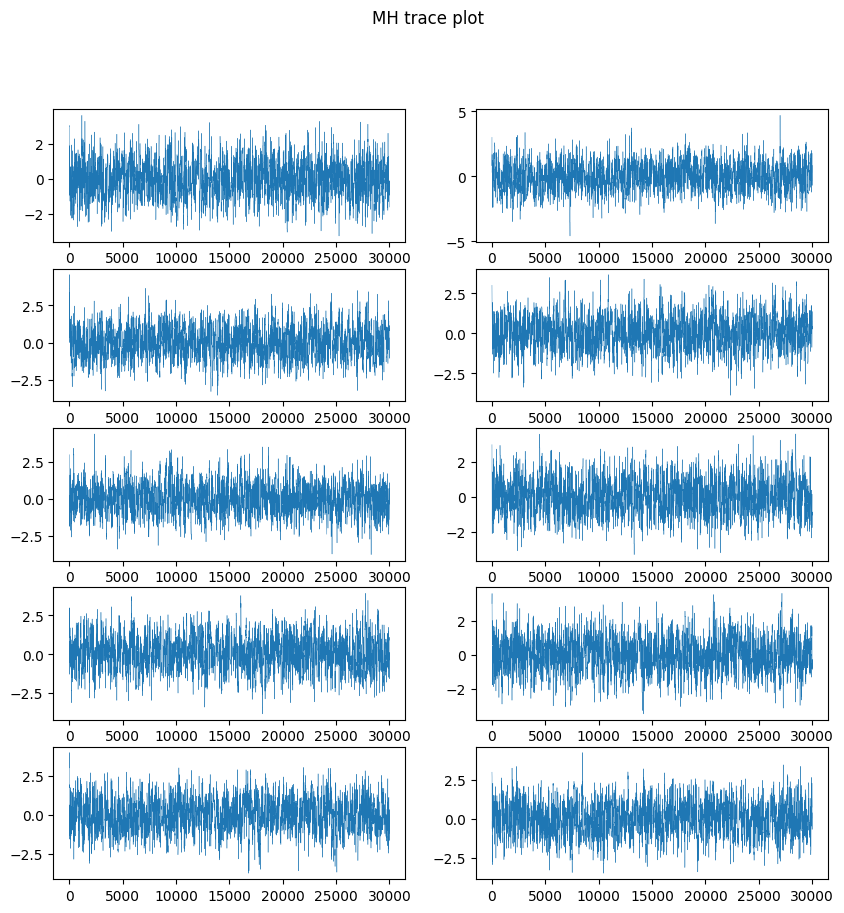

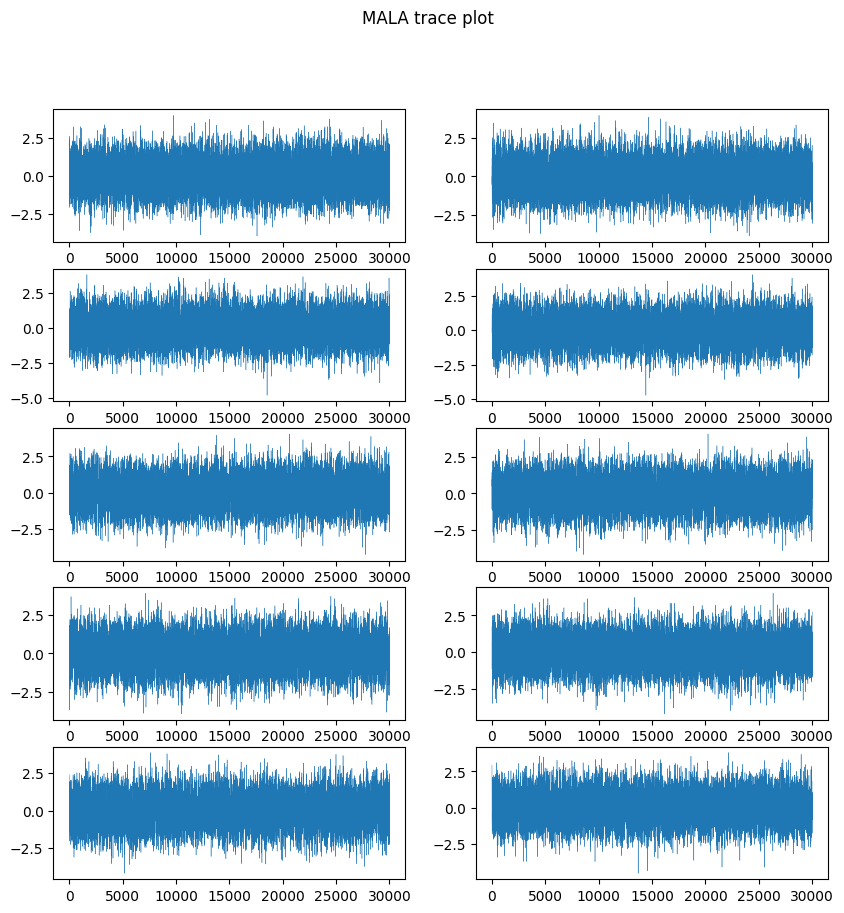

In [143]:
# Здесь нарисуйте 3 графика: trace plot (значение цепи vs итерация),
# график автокорреляции (значение ACF vs задержка по времени) и гистограмма семплов (возьмите какую-то одну размерность)

import matplotlib.pyplot as plt
fig, axs = plt.subplots(5, 2, figsize=(10, 10))
for i in range(d):
    axs[i//2][i % 2].plot(mh_chain[:, i], linewidth=0.3)

plt.suptitle('MH trace plot')
plt.show()


fig, axs = plt.subplots(5, 2, figsize=(10, 10))
for i in range(d):
    axs[i//2][i % 2].plot(mala_chain[:, i], linewidth=0.3)

plt.suptitle('MALA trace plot')
plt.show()


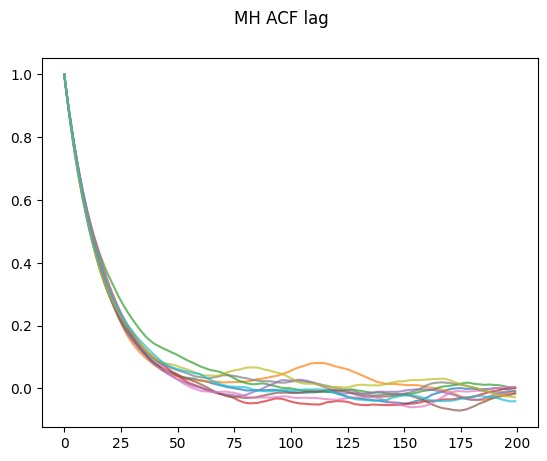

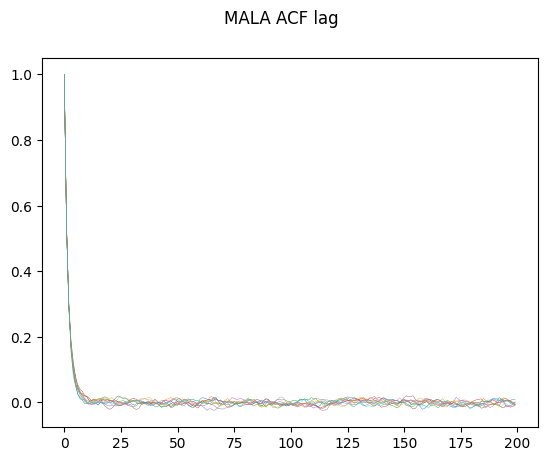

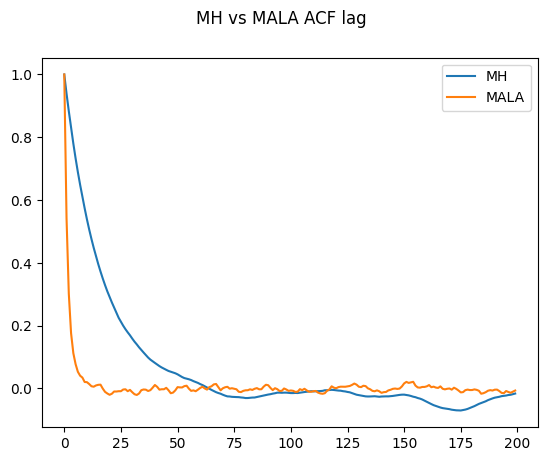

In [144]:
def ess_acf(x):
    x = x - x.mean()

    acf = np.correlate(x, x, mode='full')
    acf = acf[len(acf) // 2:]
    acf /= acf[0]

    return acf[:200]

for i in range(d):
    plt.plot(ess_acf(mh_chain[:, i]), alpha=0.7)
plt.suptitle('MH ACF lag')
plt.show()

for i in range(d):
    plt.plot(ess_acf(mala_chain[:, i]), linewidth=0.3)
plt.suptitle('MALA ACF lag')
plt.show()


plt.plot(ess_acf(mh_chain[:, 5]), label="MH")
plt.plot(ess_acf(mala_chain[:, 5]), label="MALA")
plt.legend()
plt.suptitle('MH vs MALA ACF lag')
plt.show()

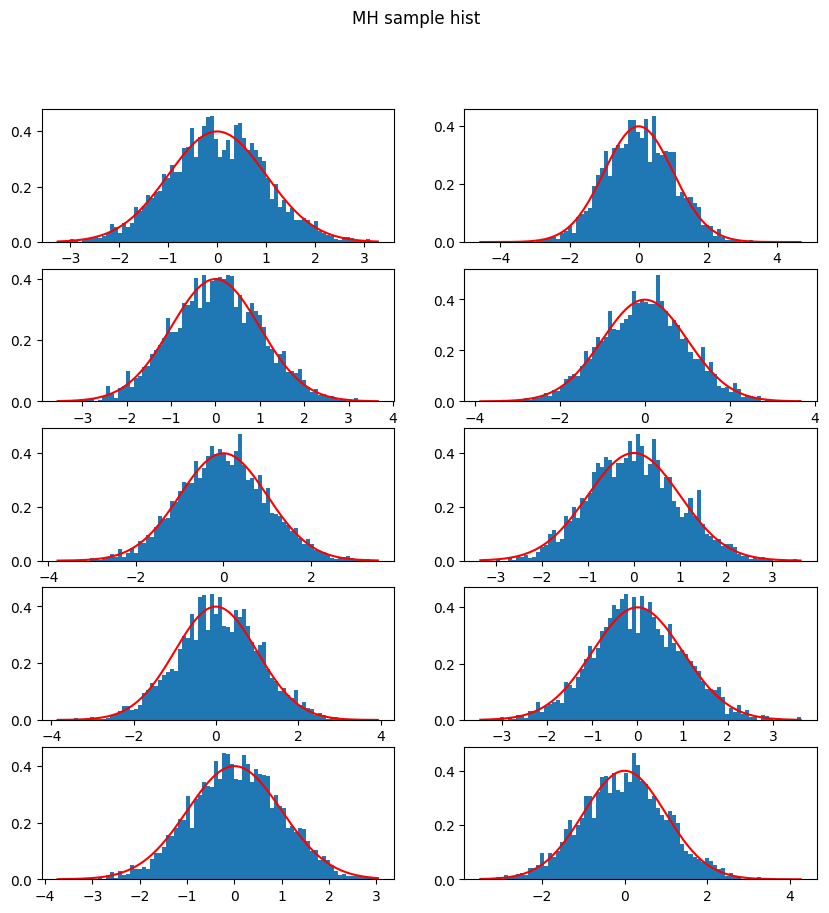

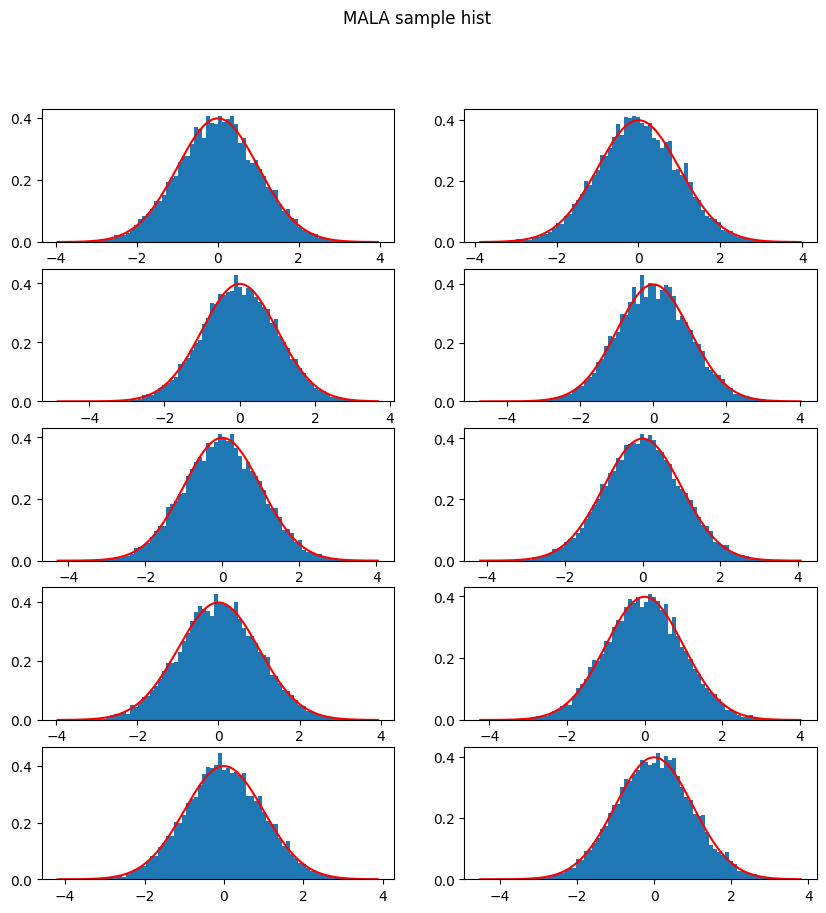

In [145]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(5, 2, figsize=(10, 10))

for i in range(d):
    sample = mh_chain[burn:][:, i]
    x_range = np.linspace(sample.min(), sample.max(), 200)
    pdf = normal_pdf(x_range, 0, 1)
    axs[i//2][i % 2].hist(sample, bins=80, density=True)
    axs[i//2][i % 2].plot(x_range, pdf, "r")

plt.suptitle('MH sample hist')
plt.show()

import matplotlib.pyplot as plt
fig, axs = plt.subplots(5, 2, figsize=(10, 10))

for i in range(d):
    sample = mala_chain[burn:][:, i]
    x_range = np.linspace(sample.min(), sample.max(), 200)
    pdf = normal_pdf(x_range, 0, 1)
    axs[i//2][i % 2].hist(sample, bins=80, density=True)
    axs[i//2][i % 2].plot(x_range, pdf, "r")

plt.suptitle('MALA sample hist')
plt.show()

Выводы:
* trace plot - MALA лучше исследует пространство и напоминает "пушистую гусеницу" (смешно, но похоже)
* ACF lag - MALA быстрее сходится к нулю, но появляются шумы (но амплитуда меньше, чем колебания MH после схождения)
* Гистограмма семплов - MALA с большей точностью описывает гауссианку